In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


Text(0.5, 1.0, 'Number of ham and spam messages')

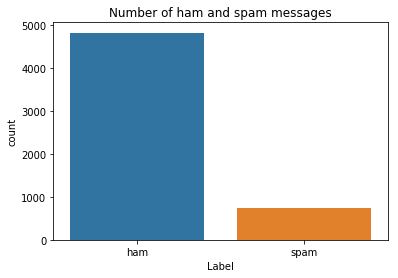

In [4]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

#### Checking the number of output classes

In [5]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

As shown above, this is an example of imbalanced classes which might negatively effect our machine learning models and give us a misleading accuracy. Therefore, there are two techniques to solve it.

- Random oversampling: Randomly duplicate examples in the minority class.
- Random undersampling: Randomly delete examples in the majority class.

In this ICP I used random oversampling technnique.

In [6]:
from sklearn.utils import resample
# Separate majority and minority classes
data_minority = df[df.v1=='spam']
data_majority = df[df.v1=='ham']

data_minority_upsampled = resample(data_minority, 
                                 replace=True,     
                                 n_samples=4825,   
                                 random_state=123) 

# Combine majority class with upsampled minority class
data = pd.concat([data_majority, data_minority_upsampled])

In [7]:
data['v1'].value_counts()

spam    4825
ham     4825
Name: v1, dtype: int64

In [8]:
df = data

In [9]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [49]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

In [50]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [51]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [52]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [57]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 6948 samples, validate on 772 samples
Epoch 1/10
6948/6948 [==============================] - 10s 1ms/step - loss: 0.0236 - acc: 0.9931 - val_loss: 0.0172 - val_acc: 0.9948
Epoch 2/10
6948/6948 [==============================] - 9s 1ms/step - loss: 0.0151 - acc: 0.9951 - val_loss: 0.0212 - val_acc: 0.9948


In [58]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [59]:
accr = model.evaluate(test_sequences_matrix,Y_test)

1930/1930 [==============================] - 1s 571us/step


In [60]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.021
  Accuracy: 0.993
